### Import Libraries

In [117]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier


### Load and Preprocess the Data

- Load your training dataset here

In [118]:
# Load the training dataset

df = pd.read_csv('amazon_employee_access_train.csv')

df.dropna()
df.shape


(32769, 10)

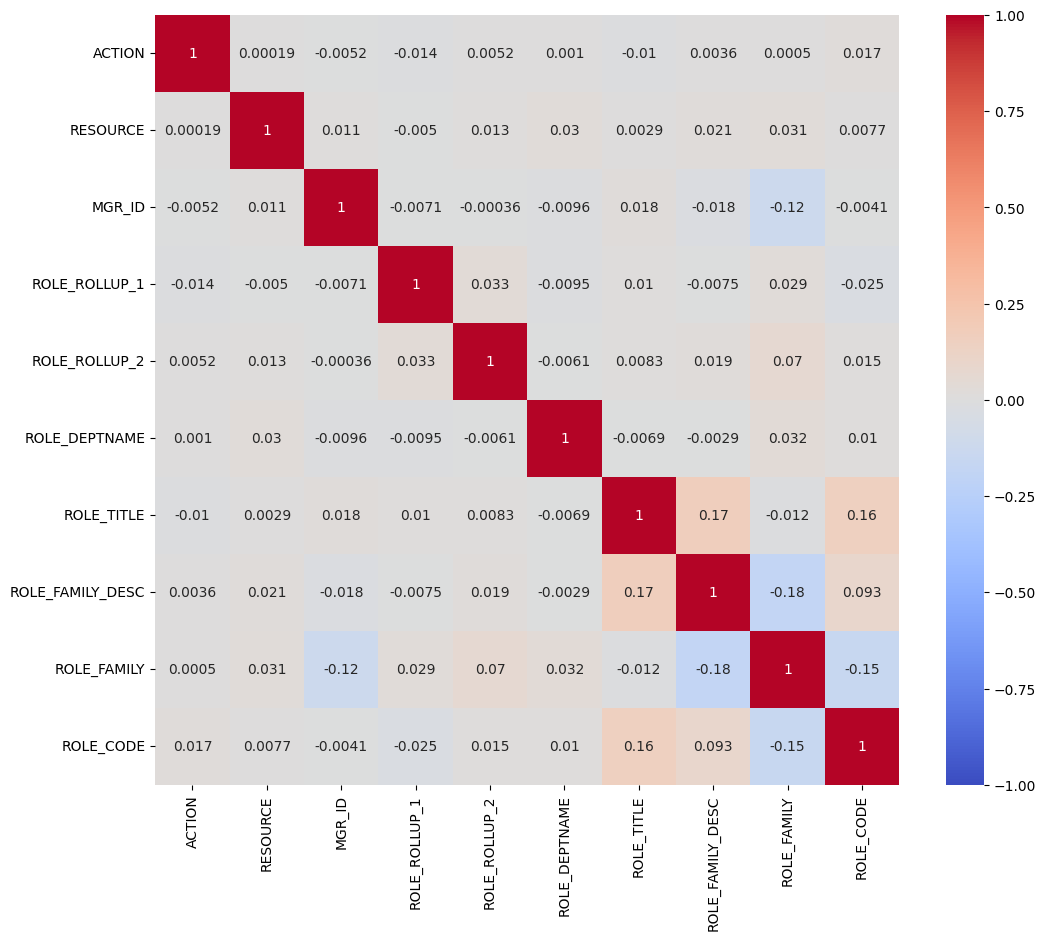

In [119]:
corr_matrix=df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.show()

### Based on the correlation, I tried to take out some of the features but there was no improvement, so I am using all the features

In [120]:
# Define features (X) and target vari'able (y)
X = df.drop(columns=['ACTION'])
y = df['ACTION']

In [121]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=123,shuffle=True, stratify=y)

### Development of four models

# XGBoost Classifier

In [122]:
import xgboost as xgb

# Define the parameter grid
param = {
    'max_depth':[3, 5, 7,8,10],
    'eta': [0.01, 0.05, 0.1,0.3]  # learning rate
    }


# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic'),
                           param_grid=param,
                           cv=3,
                           n_jobs=-1,
                           scoring='accuracy')

# Fit the grid search
grid_search.fit(X_train, y_train)

best_model_xgb = grid_search.best_estimator_
y_pred = best_model_xgb.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)

# Print the best parameters found
print("Best parameters:", grid_search.best_params_)
print("test Accuracy: %0.3f" % accuracy)


Best parameters: {'eta': 0.3, 'max_depth': 7}
test Accuracy: 0.947


# Random Forest

In [123]:
from sklearn.ensemble import RandomForestClassifier

# Define hyperparameter distribution
param_dist_rf = {
    'criterion': ['gini', 'entropy'],
    'max_features': uniform(0.1,0.9),
    'n_estimators': randint(100,500),      # Number of trees
    'max_depth': randint(5,30),           # Maximum depth of trees
    #'min_samples_split': randint(10,50),     # Minimum samples required to split a node
    #'min_samples_leaf': randint(5,20),        # Minimum samples per leaf node
    'bootstrap': [True, False]              # Use bootstrap sampling
}

# Set up RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(class_weight={0:2, 1: 1}),
    param_distributions=param_dist_rf,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=123,
    n_jobs=-1,
    verbose=1
)

# Fit RandomizedSearchCV on the training data
random_search_rf.fit(X_train, y_train)

# Get the best parameters and model
best_params_rf = random_search_rf.best_params_
best_model_rf = random_search_rf.best_estimator_

print(f"Best Parameters (Random Forest): {best_params_rf}")

# Evaluate the tuned model on the test set
y_test_pred_rf = best_model_rf.predict(X_test)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
print(f"Testing Accuracy (Random Forest): {test_accuracy_rf:.3f}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters (Random Forest): {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 26, 'max_features': np.float64(0.4256097900600827), 'n_estimators': 390}
Testing Accuracy (Random Forest): 0.949


# Neural network MLP classifier

In [124]:
from sklearn.neural_network import MLPClassifier

# Scale the data (Neural Networks benefit from Standard Scaling)
scaler_nn = MinMaxScaler(feature_range=(0, 1))
X_train_scaled_nn = scaler_nn.fit_transform(X_train)
X_test_scaled_nn = scaler_nn.transform(X_test)

# Define hyperparameter distribution
param_dist_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],  # Different network architectures
    'activation': ['relu', 'tanh', 'logistic'],       # Activation functions
    'solver': ['adam', 'sgd'],                        # Optimization algorithms
    'alpha': [0.0001, 0.001, 0.01],                  # L2 regularization parameter
    'learning_rate': ['constant', 'adaptive'],       # Learning rate schedule
}

# Set up RandomizedSearchCV
random_search_mlp = RandomizedSearchCV( 
    estimator=MLPClassifier(max_iter=300, random_state=42),
    param_distributions=param_dist_mlp,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV on the training data
random_search_mlp.fit(X_train_scaled_nn, y_train)

# Get the best parameters and model
best_params_mlp = random_search_mlp.best_params_
best_model_mlp = random_search_mlp.best_estimator_

print(f"Best Parameters (MLP): {best_params_mlp}")

# Evaluate the tuned model on the validation set
y_test_pred_mlp = best_model_mlp.predict(X_test_scaled_nn)
test_accuracy_mlp = accuracy_score(y_test, y_test_pred_mlp)
print(f"Test Accuracy (MLP): {test_accuracy_mlp:.3f}")


Best Parameters (MLP): {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100, 50), 'alpha': 0.0001, 'activation': 'relu'}
Test Accuracy (MLP): 0.942


# Logistic Regression

In [125]:
from sklearn.linear_model import LogisticRegression

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform training data
X_test_scaled = scaler.transform(X_test)        # Transform test data

# Step 4: Define the hyperparameter distribution for RandomizedSearchCV
param_dist = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # Wider range of regularization values
    'penalty': ['l1', 'l2'],                   # Include both L1 and L2 penalties
    'solver': ['lbfgs', 'liblinear', 'saga'],  # Different solvers
}

# Step 5: Set up RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=LogisticRegression(max_iter=1000),  # Base logistic regression model
    param_distributions=param_dist,              # Hyperparameter distributions
    n_iter=6,                                   # Number of parameter settings to try
    cv=5,                                        # 5-fold cross-validation
    scoring='accuracy',                          # Use accuracy as the evaluation metric
    random_state=42,                             # Ensure reproducibility
    n_jobs=-1,                                   # Use all available processors
    verbose=0                                    # Print progress during search
)

# Step 6: Fit RandomizedSearchCV on the training data
random_search.fit(X_train_scaled, y_train)

# Step 7: Get the best parameters and model
best_params = random_search.best_params_
best_model_log = random_search.best_estimator_

print(f"Best Parameters: {best_params}")

# Evaluate the tuned model on the validation set
y_test_pred = best_model_log.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Validation Accuracy: {test_accuracy:.3f}")



Best Parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 10}
Validation Accuracy: 0.942


### Based on Test Accuracies, Random Forest is the best model

### Plot Confusion Matrix for the Best Model

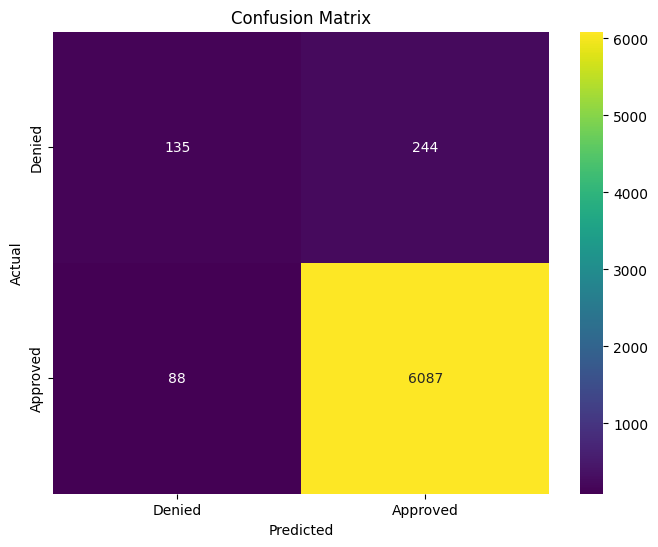

True Positive Rate: 98.57
False Positive Rate: 64.38


In [126]:
y_pred_best = best_model_rf.predict(X_test)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=['Denied', 'Approved'], yticklabels=['Denied', 'Approved'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Extracting confusion matrix values
true_positives = conf_matrix[1, 1]  # Actual Positive & Predicted Positive
true_negatives = conf_matrix[0, 0]  # Actual Negative & Predicted Negative
false_positives = conf_matrix[0, 1]  # Actual Negative & Predicted Positive
false_negatives = conf_matrix[1, 0]  # Actual Positive & Predicted Negative

# Calculate True Positive Rate (Recall)
TPR = true_positives / (true_positives + false_negatives)
print(f"True Positive Rate: {TPR * 100:.2f}")

# Calculate False Positive Rate
FPR = false_positives / (false_positives + true_negatives)
print(f"False Positive Rate: {FPR * 100:.2f}")

# Generate Predictions for the Test Dataset

- Load your test dataset here

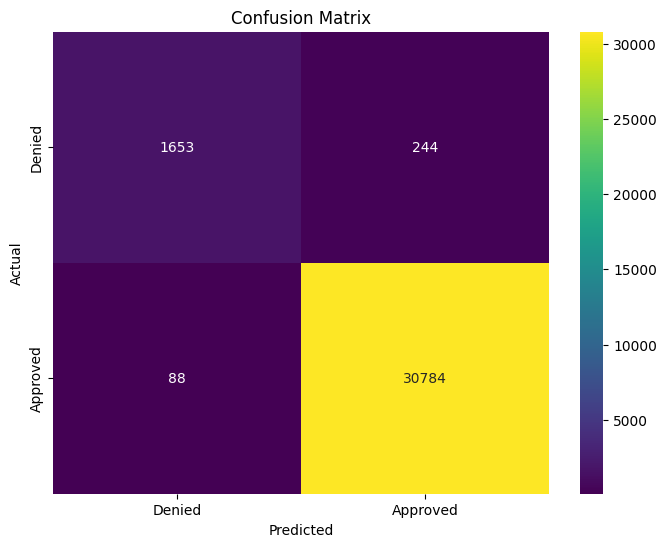

Accuracy: 94.74%
True Positive Rate: 99.71
False Positive Rate: 12.86


In [127]:
from sklearn.metrics import confusion_matrix

# Load the test dataset
test_data = pd.read_csv( 'amazon_employee_access_train.csv')


# Drop the 'ACTION' column (if present)
if 'ACTION' in test_data.columns:
    y_test_actual = test_data['ACTION']  # Save the actual labels for comparison
    test_data = test_data.drop(columns=['ACTION'])



# Predict on the test data
test_predictions = best_model_rf.predict(test_data)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_actual, test_predictions)  # Assuming binary labels (1 and 0)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=['Denied', 'Approved'], yticklabels=['Denied', 'Approved'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Extracting confusion matrix values
true_positives = conf_matrix[1, 1]  # Actual Positive & Predicted Positive
true_negatives = conf_matrix[0, 0]  # Actual Negative & Predicted Negative
false_positives = conf_matrix[0, 1]  # Actual Negative & Predicted Positive
false_negatives = conf_matrix[1, 0]  # Actual Positive & Predicted Negative


print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate True Positive Rate (Recall)
TPR = true_positives / (true_positives + false_negatives)
print(f"True Positive Rate: {TPR * 100:.2f}")

# Calculate False Positive Rate
FPR = false_positives / (false_positives + true_negatives)
print(f"False Positive Rate: {FPR * 100:.2f}")